## Gaussian Mixture Model
### Expectation - Maximization (EM) Algorithm Implementation 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as mvn
import random
pd.set_option('display.max_rows', 600)

In [3]:
def datatrans(filename, seperation):
    data = pd.read_csv(filename, header=None, sep = seperation)
    df = np.array(data.drop(axis = 1, columns = [0,1]))
    return data, df

In [4]:
def initialize(C, iterations, df):
    r = df.shape[0] 
    c = df.shape[1] 
    mu = np.zeros((C, c))
    sigma = np.zeros((C, c, c))
    gamma = np.zeros((r, C))
    pi = np.zeros(C)
    kmeans = KMeans(n_clusters = C)
    fit = kmeans.fit(df)
    pred = kmeans.predict(df)  
    clusters = np.unique(pred)
    cnt = 0
    for i in clusters:
        lab = np.where(pred == i)
        pi[cnt] = len(lab[0]) / r
        mu[cnt] = np.mean(df[lab], axis = 0)
        meandiff = df[lab] - mu[cnt,:]
        sigma[cnt,:,:] = np.dot(pi[cnt] * meandiff.T, meandiff)/df[lab].shape[0]
        cnt += 1
    return mu, sigma, pi, gamma

In [5]:
def initialize2(C, df):
    r = df.shape[0]  
    gamma = np.zeros((r, C))
    return gamma

In [6]:
def E_step(df, C, pi, mu, sigma, gamma, smooth):
    for i in range(C):
        try:
            mvn.pdf(df, mu[i,:], sigma[i])
        except:
            sigma[i][np.diag_indices(sigma[i].shape[0])] = sigma[i][np.diag_indices_from(sigma[i])] + smooth
        gamma[:,i] = pi[i] * mvn.pdf(df, mu[i,:], sigma[i])
    n_gamma = np.sum(gamma, axis = 1)[:, np.newaxis]
    gamma /= n_gamma
    return gamma

In [7]:
def M_step(df, C, gamma, pi, mu, sigma):
    pi = np.mean(gamma, axis = 0)
    mu = np.dot(gamma.T, df) / np.sum(gamma, axis = 0)[:,np.newaxis]
    for i in range(C):
        DF = df - mu[i,:]
        d_gamma = np.diag(gamma[:,i])
        mu_DF = np.matrix(DF)
        d_gamma = np.matrix(d_gamma)
        i_sigma = DF.T * d_gamma * DF
        sigma[i] = (i_sigma) / np.sum(gamma, axis = 0)[:,np.newaxis][i]
    return pi, mu, sigma

In [8]:
def MLE(df, C, r, pi, mu, sigma, gamma):
    mle = np.zeros((r, C))
    for i in range(C):
        distance = mvn(mu[i], sigma[i], allow_singular=True)
        mle[:,i] = gamma[:,i] * (np.log(pi[i]+0.00001) + distance.logpdf(df) - np.log(gamma[:,i] + 0.000001))
        mle = np.sum(mle)
        return mle

In [9]:
def iterate(df, C, mu, pi, sigma, gamma, threshold, smooth, iterations):
    p_mle = 0
    for i in range(iterations):
        pi = list(pi)
        gamma = E_step(df, C, pi, mu, sigma, gamma, smooth)
        pi = np.array(pi)
        pi, mu, sigma = M_step(df, C, gamma, pi, mu, sigma)
        r = df.shape[0]
        mle = MLE(df, C, r, pi, mu, sigma, gamma)
        if abs(mle - p_mle) < threshold:
            return gamma
        p_mle = mle
    return gamma

In [10]:
def cluster_extract(df, C, gamma):
    clusters = np.zeros((df.shape[0], C)) 
    clusters = gamma.argmax(1)
    clusters = clusters.reshape((df.shape[0],1))
    clusters = clusters+1
    return clusters

In [11]:
# Clustering Validation
def jac_rand(ground_cluster, cluster_gen):

    cluster1, cluster2 = ground_cluster, cluster_gen
    m_1_1=0
    m_0_0=0
    m_0_1=0
    m_1_0=0

    inc_m_g = np.empty([len(ground_cluster),len(ground_cluster)])
    inc_m_c = np.empty([len(ground_cluster),len(ground_cluster)])

    for i in range(len(ground_cluster)):
        for j in range(len(ground_cluster)):
            inc_m_g[i,j] = 1 if cluster1[i]==cluster1[j] else 0
            inc_m_c[i,j] = 1 if cluster2[i]==cluster2[j] else 0
            if inc_m_g[i,j]==1 and inc_m_c[i,j]==1:
                m_1_1+=1
            elif inc_m_g[i,j]==0 and inc_m_c[i,j]==0:
                m_0_0+=1
            elif inc_m_g[i,j]==1 and inc_m_c[i,j]==0:
                m_1_0+=1
            else:
                m_0_1+=1
    jaccard = m_1_1/(m_1_1 + m_0_1 + m_1_0)
    rand = (m_1_1 + m_0_0)/(m_1_1 + m_0_1 + m_1_0 + m_0_0)
    return [jaccard, rand]

In [12]:
def EM(filename, seperation, C, iterations, threshold, smooth = 0.0001,
       define = False, mu = 0, sigma = 0, pi = 0, gamma = 0):
    org, df = datatrans(filename, seperation)
    mu, sigma, pi, gamma =  initialize(C, iterations, df)
    gamma = iterate(df, C, mu, pi, sigma, gamma, threshold, smooth, iterations)
    clusters = cluster_extract(df, C, gamma)
    if df.shape[1] > 2:
        pca = PCA(n_components=2)
        pca_dim = pca.fit_transform(df)
        pca_df = pd.DataFrame(pca_dim)
        pca_df.rename(columns = {0:'PCA_1',1:'PCA_2'}, inplace = True)
        pca_df["Target"] = clusters
        labels = set(pca_df['Target'])
        plt.figure(figsize = (12,12))
        for label in labels:
            index = pca_df['Target'] == label
            plt.plot(pca_df['PCA_1'][index], pca_df['PCA_2'][index],linestyle='none', marker='o', label=label)
            plt.xlabel('PCA_1', fontsize=18)
            plt.ylabel('PCA_2', fontsize=18)
        plt.legend(numpoints=1, fontsize=18)
        plt.title("PCA", fontsize=18)
        plt.show()
        data = pd.DataFrame(df)
        data["Cluster"] = clusters
        data["Ground_truth"] = org[1]
        jac, rand = jac_rand(data["Ground_truth"], data["Cluster"])
        print("Mu :", mu)
        print("\n")
        print("Pi :", pi)
        print("\n")
        print("Sigma :", sigma)
        print("\n")
        print("For GMM on "+filename+" with number of clusters as "+str(C)+ " and number of iterations as "+str(iterations)+" and maximum threshold as "+str(threshold)+":")
        print('Jaccard : ',jac)
        print('Rand : ',rand)
        return data
    else:
        data = pd.DataFrame(df)
        data["Cluster"] = clusters
        data.rename(columns = {0:'Axis_1',1:'Axis_2'}, inplace = True)
        labels = set(data["Cluster"])
        plt.figure(figsize = (12,12))
        for label in labels:
            index = data["Cluster"] == label
            plt.plot(data['Axis_1'][index], data['Axis_2'][index],linestyle='none', marker='o', label=label)
            plt.xlabel('Axis_1', fontsize=18)
            plt.ylabel('Axis_2', fontsize=18)
        plt.legend(numpoints=1, fontsize=18)
        plt.title("Cluster Plot", fontsize=18)
        plt.show()
        data["Ground_truth"] = org[1]
        jac, rand = jac_rand(data["Ground_truth"], data["Cluster"])
        print("Mu :", mu)
        print("\n")
        print("Pi :", pi)
        print("\n")
        print("Sigma :", sigma)
        print("\n")
        print("For GMM on "+filename+" with number of clusters as "+str(C)+ " and number of iterations as "+str(iterations)+" and maximum threshold as "+str(threshold)+":")
        print('Jaccard : ',jac)
        print('Rand : ',rand)
        return data
        

* Use the function `EM(filename, seperation, C, iterations, threshold)` to generate the clustered plot and Jaccard & Rand Coefficients.
* Use appropriate strings for separation, eg: "\t" for tab space and "\s+" for single space.

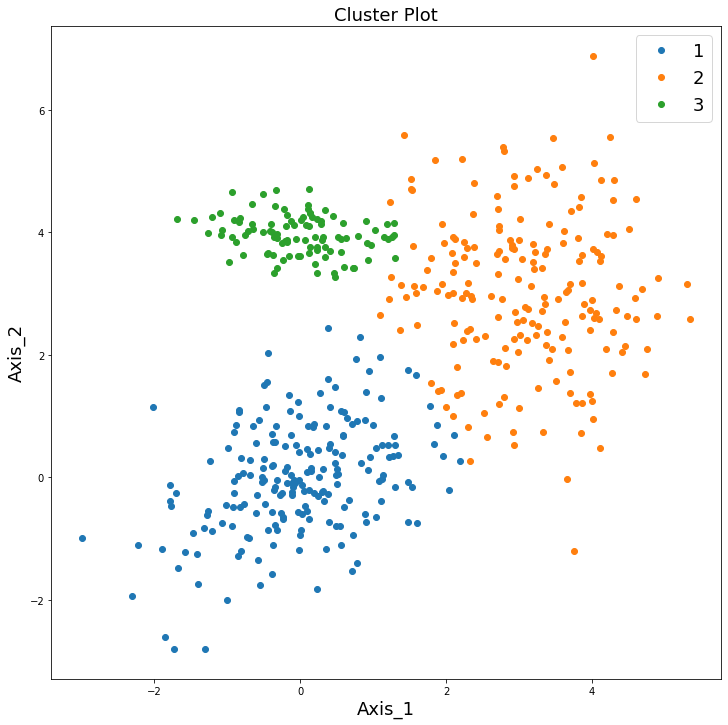

Mu : [[-0.00917104 -0.08268931]
 [ 3.16985398  2.96248473]
 [ 0.16138621  3.87975884]]


Pi : [0.394 0.368 0.238]


Sigma : [[[ 0.92965905  0.37932619]
  [ 0.37932619  0.84677622]]

 [[ 0.96222748 -0.03618457]
  [-0.03618457  1.60614247]]

 [[ 0.46059906 -0.06042046]
  [-0.06042046  0.1063244 ]]]


For GMM on GMM.txt with number of clusters as 3 and number of iterations as 100 and maximum threshold as 1e-09:
Jaccard :  0.8733561672798004
Rand :  0.95208


In [13]:
demo = EM("GMM.txt", "\s+", C = 3, iterations = 100, threshold = 1e-09, smooth = 1e-09, 
          mu = [[1, 1], [3.5, 5.3], [0, 4]], pi = [0.1,0.8,0.1], sigma = [[[1, 0.5], [0.5, 1]],[[1, 0], [0, 2]],[[0.5, 0], [0,0.1]]])



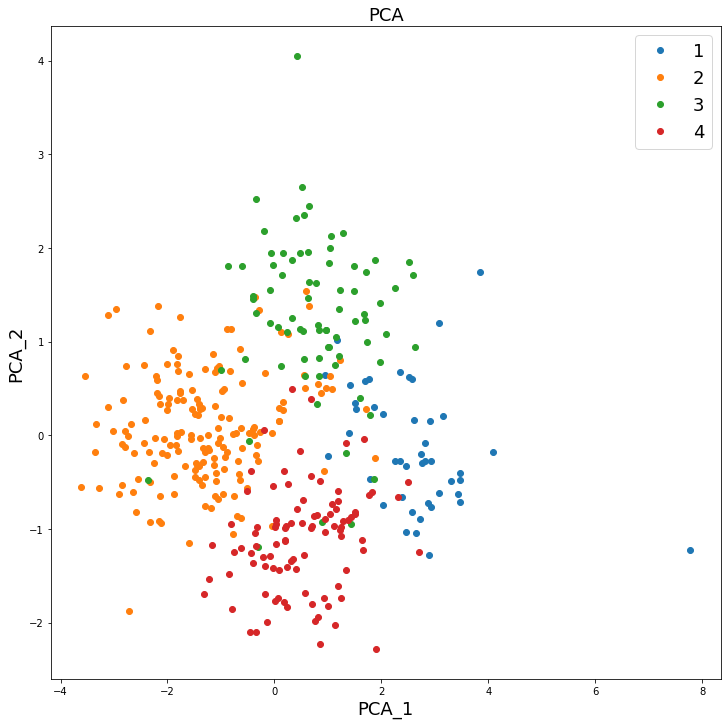

Mu : [[-0.819      -0.89212069 -1.03293103 -0.67206897 -0.27051724  0.18931034
   0.72793103  0.96586207  0.815      -0.095      -0.36051724 -0.13275862
   0.065       0.38524138  0.58715517  0.49862069]
 [-0.35994667  0.05893333  1.05733333  0.56453333 -0.01046667 -0.19466667
  -0.48333333 -0.71634667 -0.55366667  0.68346667  0.58585333  0.24757333
  -0.04237333 -0.32084    -0.53662    -0.3928    ]
 [ 0.10463953 -0.10832558 -0.53076744 -0.61586047 -0.52218605 -0.41062791
  -0.33502326 -0.12837209  0.27997674  0.60090698  0.34663953  0.08677907
  -0.03818605  0.0339186   0.1182907   0.40209302]
 [-0.5725     -0.45358696 -0.11619565  0.31782609  0.60967391  0.52054348
   0.25934783  0.00934783 -0.21130435 -0.31826087 -0.0181413   0.23032609
   0.25401087  0.11493478  0.08667391 -0.16054348]]


Pi : [0.15025907 0.38860104 0.22279793 0.23834197]


Sigma : [[[ 0.46758143  0.27388871  0.16093407 ... -0.08325733 -0.17102236
   -0.12603207]
  [ 0.27388871  0.57686912  0.28951915 ... -0.15907 

In [14]:
data_cho = EM("cho.txt", "\t", 4, 100, 1e-08 )

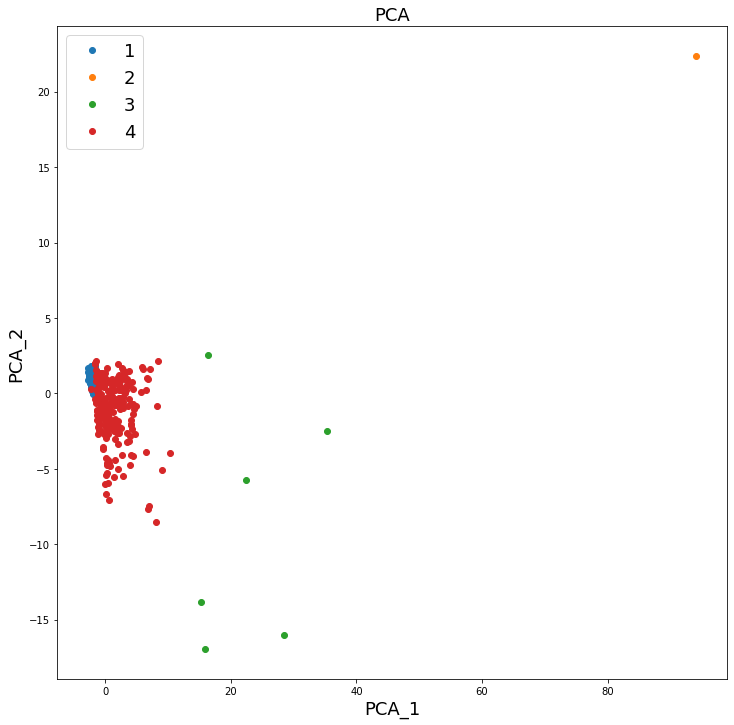

Mu : [[ 1.          0.96880342  0.98196581  1.0002849   0.93230769  0.76333333
   0.63495726  0.58837607  0.60074074  0.82153846  0.85410256  0.92282051]
 [ 1.          2.67        2.41        3.75        6.18       38.8
  86.92       25.58       14.81        6.73        2.72        2.42      ]
 [ 1.          1.12333333  2.19666667  3.77833333  3.39333333 10.59833333
  13.695      14.39666667  8.97333333  8.405       7.62166667  6.56333333]
 [ 1.          1.07169811  1.39528302  1.76968553  1.70742138  2.40213836
   2.58471698  2.79754717  2.35075472  2.11169811  2.2536478   2.46427673]]


Pi : [0.67891683 0.00193424 0.01160542 0.30754352]


Sigma : [[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  3.74922202e-02  2.24120142e-02  1.50242361e-02
    2.01780124e-02  1.13389528e-02  1.14001367e-02  1.34520347e-02
    9.

In [15]:
data_iyer = EM("iyer.txt", "\t", 4, 100, 1e-08 )